In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

I try to extend dataset of caltech101 form ImangeNet images, as we have around 80-85 classes similar to imagenet  
https://www.kaggle.com/datasets/ashishlotake/extendedcaltech101

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import shutil, pathlib
from glob import glob
import os
import warnings
warnings.filterwarnings('ignore')

main_folder = "/kaggle/input/extendedcaltech101/101_ObjectCategories"

In [4]:
!ls /kaggle/input/extendedcaltech101/101_ObjectCategories

Motorbikes    cougar_body      garfield      menorah	soccer_ball
accordion     cougar_face      gerenuk	     metronome	stapler
airplanes     crab	       gramophone    minaret	starfish
anchor	      crayfish	       grand_piano   nautilus	stegosaurus
ant	      crocodile        hawksbill     octopus	stop_sign
barrel	      crocodile_head   headphone     okapi	strawberry
bass	      cup	       hedgehog      pagoda	sunflower
beaver	      dalmatian        helicopter    panda	tick
binocular     dollar_bill      ibis	     pigeon	trilobite
bonsai	      dolphin	       inline_skate  pizza	umbrella
brain	      dragonfly        joshua_tree   platypus	watch
brontosaurus  electric_guitar  kangaroo      pyramid	water_lilly
buddha	      elephant	       ketch	     revolver	wheelchair
butterfly     emu	       lamp	     rhino	wild_cat
camera	      euphonium        laptop	     rooster	windsor_chair
cannon	      ewer	       leopards      saxophone	wrench
car_side      faces	       llama	     schooner	yin_yang


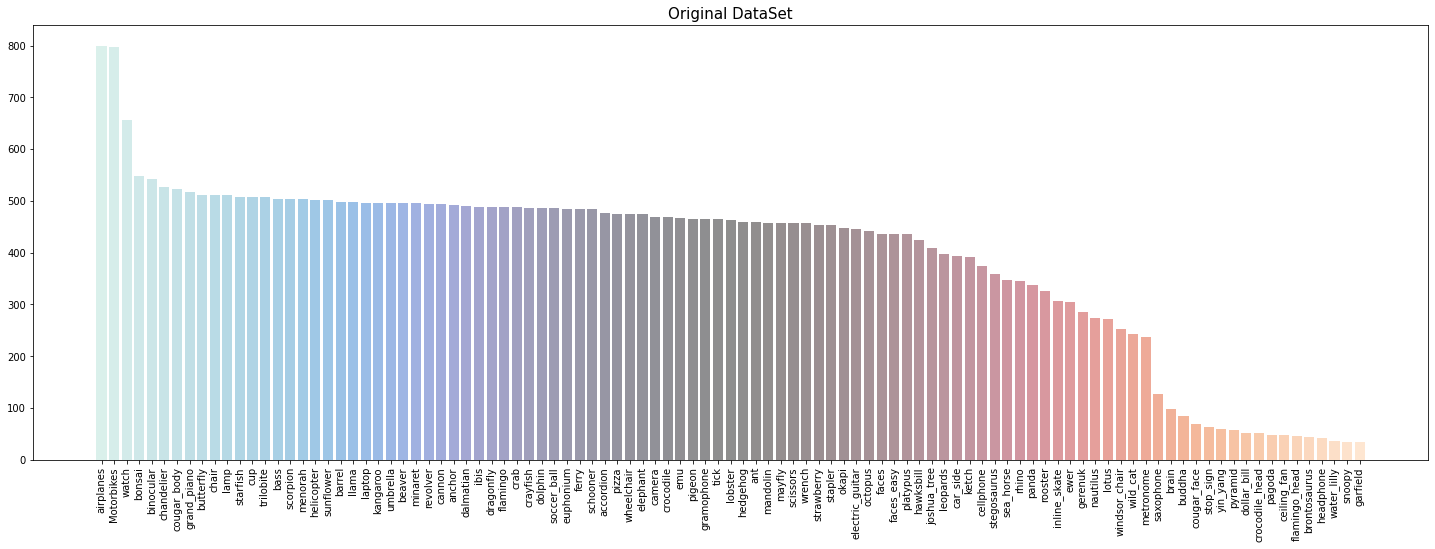

In [5]:
def plot_folder(folder_name, plot_title="Count Plot", color = 'yellow', show_cnt=True, show_xticks=False):
    count_dict = {i:len(os.listdir(folder_name+"/"+i)) for i in os.listdir(folder_name)}
    dic2=dict(sorted(count_dict.items(),key= lambda x:x[1] , reverse=True))

    palette = sns.color_palette("icefire", len(dic2))
    plt.title(plot_title, fontsize=15)
    plt.bar(*zip(*dic2.items()), color=palette, alpha=0.5)
    plt.xticks(rotation=90)
    y = sorted(count_dict.values())[-4]
    y_count = sum(count_dict.values())
    if show_cnt:
        plt.text(10, y, f'{y_count} images', style='italic',bbox={'facecolor': color ,'alpha': 0.5, 'pad': 9})
    if show_xticks:
        pass
    else:
        plt.xticks([])
    plt.grid(False)



main_folder = "/kaggle/input/extendedcaltech101/101_ObjectCategories"
plt.figure(figsize=(25,8))
plot_folder(main_folder, plot_title="Original DataSet", color='green' , show_cnt=False, show_xticks=True)

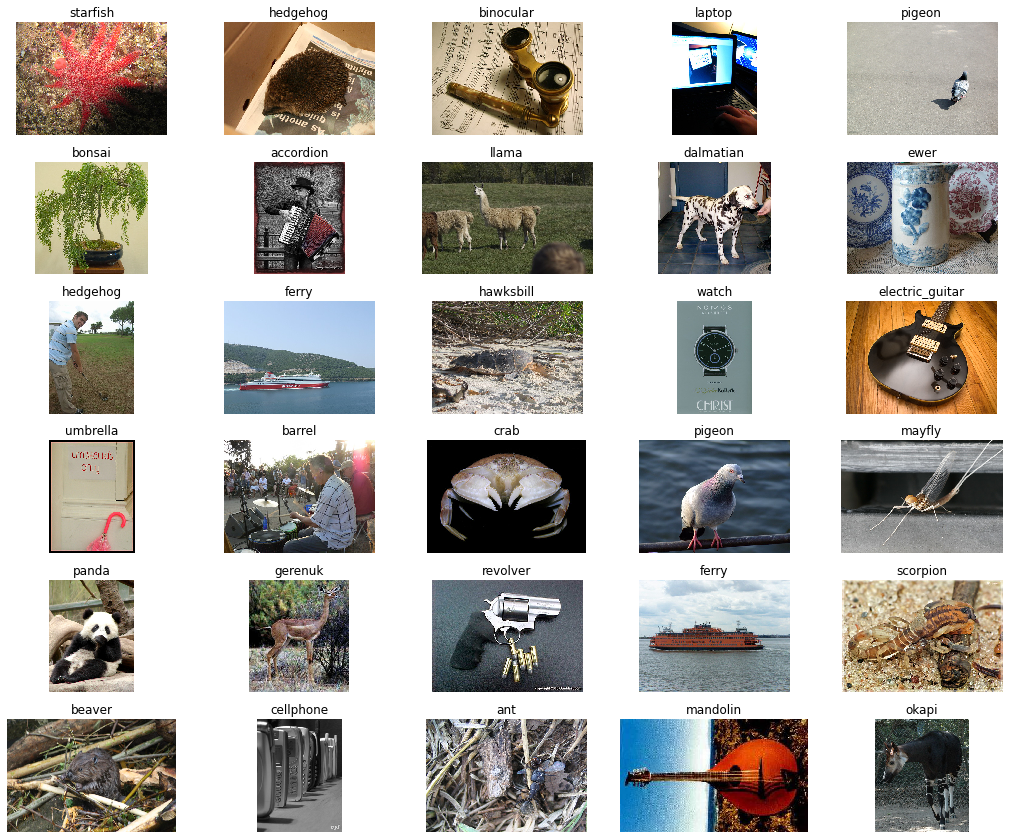

In [6]:
all_img = glob(main_folder+"/*/*.jpg") 


from skimage.io import imread, imshow
# lets view few images
np.random.seed(42)
sub_set = np.random.choice(all_img, 30)
plt.figure(figsize=(15, 12))
for i in range(30):
  ax = plt.subplot(6,5,i+1)
  img = imread(sub_set[i])
  imshow(img)
  label = sub_set[i].split("/")[-2]
  plt.title(label)
  plt.axis(False)

plt.show();

# Stratified Splitting data 

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit


df_img = pd.DataFrame(all_img, columns=["images_path"])

## adding a column to dataframe for image category
df_img["img_cat"] = df_img["images_path"].apply(lambda x: x.split("/")[-2])

def strat_train_val_test_split(df_img):
    '''
    df_img --> pandas DataFrame
    
    input pandas dataframe and return train val test split in using
    stratified sampling technique
    '''
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.11,random_state=42)

    for train_index, test_index in split.split(df_img, df_img["img_cat"]):
        strat_train_set = df_img.loc[train_index]
        test_set_path = df_img.loc[test_index]

    ## split strat_train_set --> train and split

    strat_train_set.reset_index(inplace=True)  ## reset the index, 
    strat_train_set.drop("index",axis=1, inplace=True) ## drop the "index"

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.12,random_state=42)

    for train_index, test_index in split.split(strat_train_set, strat_train_set["img_cat"]):
        train_set_path = strat_train_set.loc[train_index]
        val_set_path = strat_train_set.loc[test_index]
    
    print(f"Train Dataset:      {train_set_path.shape[0]} images\nTest Dataset:       {test_set_path.shape[0]} images\nValidation Dataset: {val_set_path.shape[0]} images")
    return train_set_path, val_set_path , test_set_path


train_set_path, val_set_path , test_set_path = strat_train_val_test_split(df_img)

train_data = list(train_set_path["images_path"])
val_data = list(val_set_path["images_path"]) 
test_data = list(test_set_path["images_path"])

Train Dataset:      30948 images
Test Dataset:       4347 images
Validation Dataset: 4221 images


In [8]:
val_set_path.images_path.iloc[0]

'/kaggle/input/extendedcaltech101/101_ObjectCategories/pizza/3026526794_8634dd097f.jpg'

# Copy img to dir

In [9]:
import pathlib
from tqdm import tqdm

def make_subset(subset_name, dataset,classes, new_base_dir):
    '''
    subset name --> train/test/val
    dataset --> list form
    classes --> category name
    new_base_dir --> folder where we want to copy splitted data
    '''
    new_base_dir = pathlib.Path(new_base_dir)
    try:
        os.mkdir(new_base_dir)
    except:
        pass
    for class_name in classes:
        dir = new_base_dir/subset_name/class_name
        os.makedirs(dir)
    for i in tqdm(range(len(dataset))):
        fname = dataset[i]
        name = str(i)+train_data[0].split("/")[-1]
        shutil.copy(src= fname, dst=new_base_dir / subset_name / fname.split("/")[-2] / name)

        
classes = os.listdir(main_folder)


if os.path.exists("splitted_dataset"):
    pass
else:
    make_subset("train", train_data, classes, new_base_dir="splitted_dataset")
    make_subset("validation",val_data, classes, new_base_dir="splitted_dataset")
    make_subset("test",test_data, classes, new_base_dir="splitted_dataset")

100%|██████████| 4347/4347 [00:13<00:00, 322.98it/s]


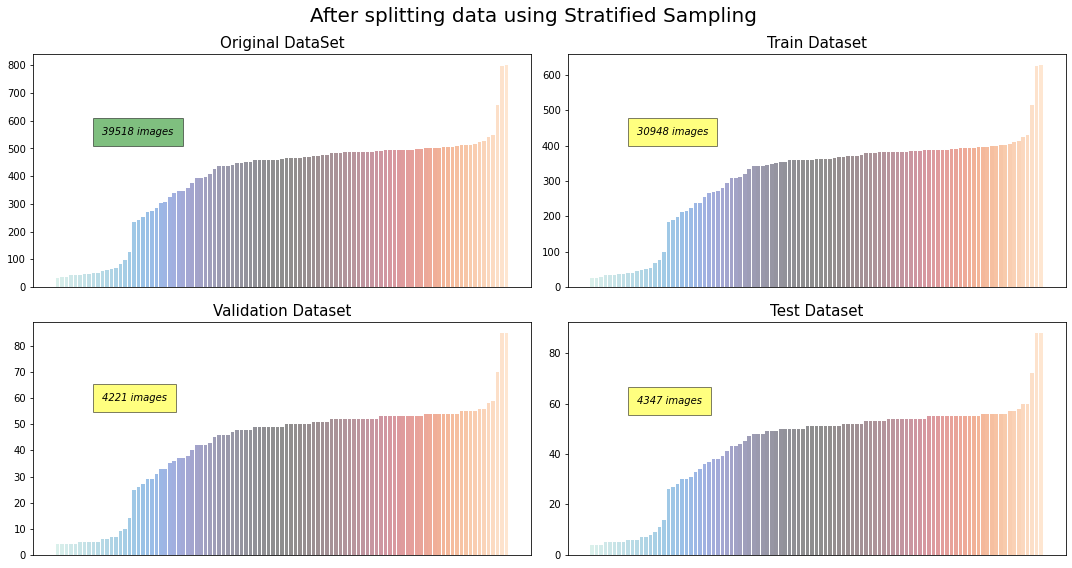

In [10]:
def plot_folder(folder_name, plot_title="Count Plot", color = 'yellow'):
    count_dict = {i:len(os.listdir(folder_name+"/"+i)) for i in os.listdir(folder_name)}
    dic2=dict(sorted(count_dict.items(),key= lambda x:x[1]))

    palette = sns.color_palette("icefire", len(dic2))
    plt.title(plot_title, fontsize=15)
    plt.bar(*zip(*dic2.items()), color=palette, alpha=0.5)
    plt.xticks(rotation=90)
    y = sorted(count_dict.values())[-4]
    y_count = sum(count_dict.values())
    plt.text(10, y, f'{y_count} images', style='italic',
             bbox={'facecolor': color ,'alpha': 0.5, 'pad': 9})
    plt.xticks([])
    plt.grid(False)



plt.figure(figsize=(15,8))
plt.suptitle('After splitting data using Stratified Sampling ',fontsize=20)

plt.subplot(2,2,1)
plot_folder(main_folder, plot_title="Original DataSet", color='green')

plt.subplot(2,2,2)
plot_folder("./splitted_dataset/train", plot_title="Train Dataset")

plt.subplot(2,2,3)
plot_folder("./splitted_dataset/validation", plot_title="Validation Dataset")

plt.subplot(2,2,4)
plot_folder("./splitted_dataset/test", plot_title="Test Dataset")

plt.tight_layout()

# Loading Images 

In [11]:
# preprocessing 
# - Resizing of the images from 32x32 to 227x227. The AlexNet network input expects a 227x227 image.
# - batch_size=32

import tensorflow as tf

new_base_dir = pathlib.Path("splitted_dataset")

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    new_base_dir/ "train",
    color_mode="rgb",
    image_size=(227,227),
    batch_size=32,
)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    new_base_dir/ "validation",
    color_mode="rgb",
    image_size=(227,227),
    batch_size=32,
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    new_base_dir/ "test",
    color_mode="rgb",
    image_size=(227,227),
    batch_size=32,
)

Found 30948 files belonging to 101 classes.


2022-10-08 13:14:28.838505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 13:14:28.936538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 13:14:28.937309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 13:14:28.940081: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 4221 files belonging to 101 classes.
Found 4347 files belonging to 101 classes.


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [14]:
for data_batch, label_batch in train_dataset:
    print("data batch shape: ", data_batch.shape)
    print("label batch shape: ", label_batch.shape)
    break

data batch shape:  (32, 227, 227, 3)
label batch shape:  (32,)


# Defining Model

- Optimizer = SGD
- Learning Rate = 0.01
- Momentum = 0.3
- Ephocs = 61

In [15]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers

In [18]:
input = keras.Input(shape=(227,227,3))
x = layers.Rescaling(1./255)(input) # Rescale inputs to the [0, 1] range by dividing them by 255.
# 1st layer
x = layers.Conv2D(filters=90, kernel_size=(11,11), strides=(4,4), activation='relu')(x)
x = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = layers.BatchNormalization()(x)

# 2nd layer
x = layers.Conv2D(filters= 256, kernel_size=(5,5),strides=(1,1),  activation='relu', padding="valid")(x)
x = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = layers.BatchNormalization()(x)

# 3rd layer
x = layers.Conv2D(filters= 384, kernel_size=(3,3),strides=(1,1),  activation='relu', padding='valid')(x)
x = layers.BatchNormalization()(x)

# 4th layer
x = layers.Conv2D(filters= 384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')(x)
x = layers.BatchNormalization()(x)

# 5th layer
x = layers.Conv2D(filters= 256, kernel_size=(3,3),  strides=(1,1), activation='relu', padding='valid')(x)
x = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = layers.BatchNormalization()(x)

# flattening
x = layers.Flatten()(x)

# 1st dense layer
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)

# 2nd dense layer
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)

# output sotfmax layer
output = layers.Dense(101, activation='softmax')(x)

alexnet_scratch = keras.Model(inputs = input, outputs=output)


## compiling model with Adam Optimizer
alexnet_scratch.compile(loss='sparse_categorical_crossentropy', 
                        optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.3),
                        metrics=['accuracy'])


callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_extended_01 = alexnet_scratch.fit(
    train_dataset,
    epochs=62,
    validation_data=validation_dataset,
    callbacks=callbacks
    )

Epoch 1/62
968/968 [==============================] - 63s 64ms/step - loss: 4.7398 - accuracy: 0.0783 - val_loss: 7.4920 - val_accuracy: 0.0526
Epoch 2/62
968/968 [==============================] - 63s 65ms/step - loss: 4.2069 - accuracy: 0.1361 - val_loss: 7.8900 - val_accuracy: 0.0557
Epoch 3/62
968/968 [==============================] - 62s 64ms/step - loss: 3.8458 - accuracy: 0.1750 - val_loss: 23.6273 - val_accuracy: 0.0135
Epoch 4/62
968/968 [==============================] - 61s 63ms/step - loss: 3.5894 - accuracy: 0.2100 - val_loss: 7.0040 - val_accuracy: 0.0782
Epoch 5/62
968/968 [==============================] - 62s 64ms/step - loss: 3.3252 - accuracy: 0.2453 - val_loss: 8.7272 - val_accuracy: 0.0561
Epoch 6/62
968/968 [==============================] - 62s 64ms/step - loss: 3.1232 - accuracy: 0.2779 - val_loss: 4.2095 - val_accuracy: 0.1509
Epoch 7/62
968/968 [==============================] - 62s 64ms/step - loss: 2.9625 - accuracy: 0.3015 - val_loss: 3.9573 - val_accuracy

# Plot perfomrace 

In [19]:
def plot_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history["val_accuracy"]
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(15,6))

    epochs = range(1, len(acc)+1)
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, "b--", label="Train Accuracy")
    plt.plot(epochs, val_acc, "g", label="Val Accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, "b--", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

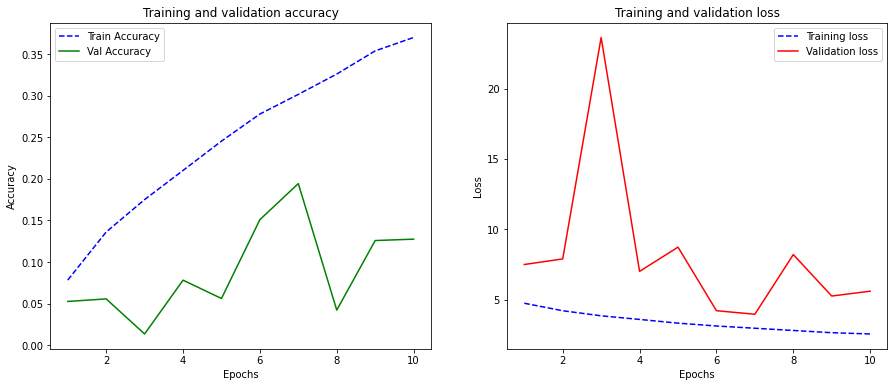

In [20]:
plot_performance(history_extended_01)

In [22]:
test_loss, test_acc = alexnet_scratch.evaluate(test_dataset)
print(f"Test accuracy Extended Data: {test_acc:.3f}--------Test loss Extended Data:  {test_loss:.3f}")


136/136 [==============================] - 7s 49ms/step - loss: 5.6493 - accuracy: 0.1233
Test accuracy Extended Data: 0.123--------Test loss Extended Data:  5.649


This wasn't a fruitful endevaour as the models' performance is very poor.

# Data Augmentation


In [26]:
data_augmentation = Sequential([
  layers.RandomFlip('horizontal'), ## Applies horizontal flipping toa random 50% of the images that go through it
  layers.RandomRotation(0.1), ## Rotates the input images by a random value in the range[–10%, +10%] (these are fractions of a full circle—in degrees, the range would be [–36 degrees, +36 degrees])
  layers.RandomZoom(0.2), ## Zooms in or out of the image by a random factor in the range [-20%, +20%]
  ])


input = keras.Input(shape=(227,227,3))
x = data_augmentation(input)
x = layers.Rescaling(1./255)(x) # Rescale inputs to the [0, 1] range by dividing them by 255.
# 1st layer
x = layers.Conv2D(filters=90, kernel_size=(11,11), strides=(4,4), activation='relu')(x)
x = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = layers.BatchNormalization()(x)

# 2nd layer
x = layers.Conv2D(filters= 256, kernel_size=(5,5),strides=(1,1),  activation='relu', padding="valid")(x)
x = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = layers.BatchNormalization()(x)

# 3rd layer
x = layers.Conv2D(filters= 384, kernel_size=(3,3),strides=(1,1),  activation='relu', padding='valid')(x)
x = layers.BatchNormalization()(x)

# 4th layer
x = layers.Conv2D(filters= 384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')(x)
x = layers.BatchNormalization()(x)

# 5th layer
x = layers.Conv2D(filters= 256, kernel_size=(3,3),  strides=(1,1), activation='relu', padding='valid')(x)
x = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = layers.BatchNormalization()(x)

# flattening
x = layers.Flatten()(x)

# 1st dense layer
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)

# 2nd dense layer
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)

# output sotfmax layer
output = layers.Dense(101, activation='softmax')(x)

alexnet_scratch_02 = keras.Model(inputs = input, outputs=output)


## compiling model with Adam Optimizer
alexnet_scratch_02.compile(loss='sparse_categorical_crossentropy', 
                        optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.3),
                        metrics=['accuracy'])


callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_extended_02 = alexnet_scratch_02.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
    )

Epoch 1/30
968/968 [==============================] - 65s 66ms/step - loss: 4.8315 - accuracy: 0.0703 - val_loss: 5.4640 - val_accuracy: 0.0429
Epoch 2/30
968/968 [==============================] - 64s 66ms/step - loss: 4.3463 - accuracy: 0.1164 - val_loss: 4.8212 - val_accuracy: 0.1149
Epoch 3/30
968/968 [==============================] - 64s 66ms/step - loss: 4.0310 - accuracy: 0.1492 - val_loss: 4.2098 - val_accuracy: 0.1239
Epoch 4/30
968/968 [==============================] - 63s 65ms/step - loss: 3.7791 - accuracy: 0.1760 - val_loss: 9.6369 - val_accuracy: 0.0545
Epoch 5/30
968/968 [==============================] - 64s 65ms/step - loss: 3.6253 - accuracy: 0.1981 - val_loss: 6.3141 - val_accuracy: 0.0457
Epoch 6/30
968/968 [==============================] - 64s 65ms/step - loss: 3.4874 - accuracy: 0.2199 - val_loss: 11.2110 - val_accuracy: 0.0258


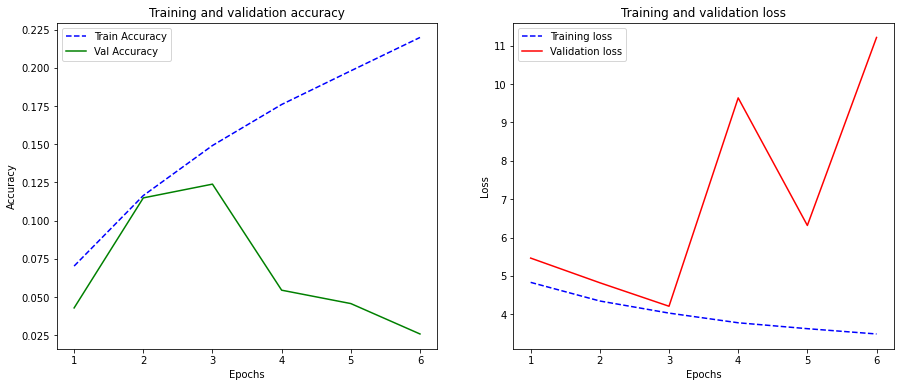

In [27]:
plot_performance(history_extended_02)

In [28]:
test_loss, test_acc = alexnet_scratch_02.evaluate(test_dataset)
print(f"Test accuracy Extended Data: {test_acc:.3f}--------Test loss Extended Data:  {test_loss:.3f}")


136/136 [==============================] - 7s 47ms/step - loss: 11.3446 - accuracy: 0.0230
Test accuracy Extended Data: 0.023--------Test loss Extended Data:  11.345


---
# A simpler mode

In [23]:
## defining model
## Define data augmentation
data_augmentation = Sequential([
  layers.RandomFlip('horizontal'), ## Applies horizontal flipping toa random 50% of the images that go through it
  layers.RandomRotation(0.1), ## Rotates the input images by a random value in the range[–10%, +10%] (these are fractions of a full circle—in degrees, the range would be [–36 degrees, +36 degrees])
  layers.RandomZoom(0.2), ## Zooms in or out of the image by a random factor in the range [-20%, +20%]
  ])

from keras.regularizers import l2
inputs = keras.Input(shape=(227,227,3))
x = data_augmentation(inputs) ## add data sugmentation as a part of model
x = layers.Rescaling(1./255)(x) ## rescaling, we will convert the pixle range form 0-255 to 0-1

x = layers.Conv2D(32, 3, activation='relu',  )(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.Conv2D(64, 3, activation='relu', )(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.Conv2D(128, 3, activation='relu', )(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.Conv2D(256, 3, activation='relu', )(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.Conv2D(256, 3, activation='relu', )(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(101, activation='softmax')(x)

model3 = keras.Model(inputs, outputs)


## compile
model3.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

## define callback

callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


     
history3 = model3.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset,
                    callbacks=callbacks)




Epoch 1/30
968/968 [==============================] - 68s 68ms/step - loss: 4.1702 - accuracy: 0.0719 - val_loss: 3.9067 - val_accuracy: 0.1173
Epoch 2/30
968/968 [==============================] - 66s 68ms/step - loss: 3.6414 - accuracy: 0.1627 - val_loss: 3.3279 - val_accuracy: 0.2251
Epoch 3/30
968/968 [==============================] - 66s 68ms/step - loss: 3.3222 - accuracy: 0.2169 - val_loss: 3.1078 - val_accuracy: 0.2755
Epoch 4/30
968/968 [==============================] - 66s 68ms/step - loss: 3.1018 - accuracy: 0.2614 - val_loss: 2.9837 - val_accuracy: 0.2900
Epoch 5/30
968/968 [==============================] - 66s 68ms/step - loss: 2.9423 - accuracy: 0.2908 - val_loss: 2.7979 - val_accuracy: 0.3269
Epoch 6/30
968/968 [==============================] - 66s 68ms/step - loss: 2.8409 - accuracy: 0.3101 - val_loss: 2.7066 - val_accuracy: 0.3412
Epoch 7/30
968/968 [==============================] - 66s 67ms/step - loss: 2.7542 - accuracy: 0.3273 - val_loss: 2.7233 - val_accuracy:

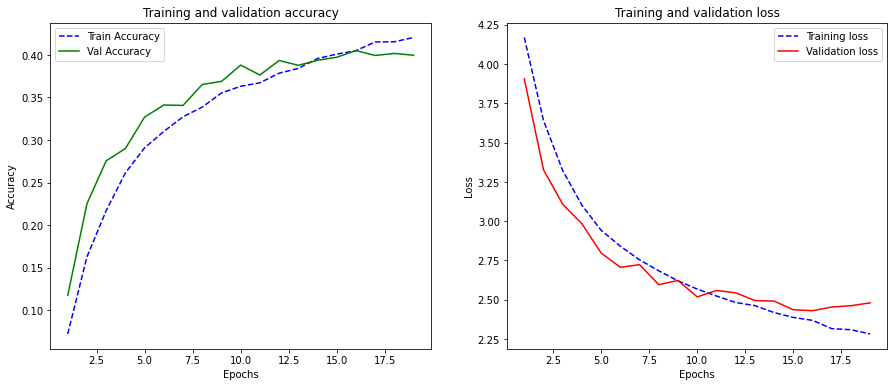

In [24]:
plot_performance(history3)

In [25]:
test_loss, test_acc = model3.evaluate(test_dataset)
print(f"Test accuracy Extended Data: {test_acc:.3f}--------Test loss Extended Data:  {test_loss:.3f}")


136/136 [==============================] - 8s 53ms/step - loss: 2.5136 - accuracy: 0.3936
Test accuracy Extended Data: 0.394--------Test loss Extended Data:  2.514
